https://www.kaggle.com/competitions/ieee-fraud-detection

Este notebook engloba os seguinte passos:

* Feature Engineering
    * Tratando Colunas com Valores Faltantes (deletar colunas com 75% de valores faltantes)
    * Tratando Colunas com valores únicos (deletar)
    * Tratando Linhas com Valores Faltantes (deletar linhas com 75% de valores faltantes)
    * Substituindo NaNs remanescentes por média e moda
    * Codificação de variáveis categóricas
* Redução de dimensionalidade
    * Seleção de atributos com teste do Qui-Quadrado (top 75 e todos)
* Separação entre base de treino, de teste e de validação, a partir da base de treino
* Balanceamento de classes
    * Oversample
        * SMOTE
        * AdaSyn
* Treinamento dos algoritmos e análise de desempenho, com validação cruzada (estratificada, 10 folds)
    * Algoritmos utilizados
        * Extra Trees
        * Decision Tree
        * CatBoost
        * Gradient Boost Classifier
        * AdaBoost
        * KNN
    * Métricas de desempenho
        * F1-score positivo (iteração por iteração)
        * F1-score negativo (iteração por iteração)
        * avaliação de thresholds
        * Wall time

# Sobre os Dados

## Tabela Transação

* `TransactionDT`: timedelta from a given reference datetime (not an actual timestamp)

* `TransactionAMT`: transaction payment amount in USD

* `ProductCD`: product code, the product for each transaction

* `card1 - card6`: payment card information, such as card type, card category, issue bank, country, etc.

* `addr`: address

* `dist`: distance

* `P_ and (R__) emaildomain`: purchaser and recipient email domain

* `C1-C14`: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.

* `D1-D15`: timedelta, such as days between previous transaction, etc.

* `M1-M9`: match, such as names on card and address, etc.

* `Vxxx`: Vesta engineered rich features, including ranking, counting, and other entity relations.

### Categorical Features

* `ProductCD`

* `card1 - card6`

* `addr1, addr2`

* `P_emaildomain`

* `R_emaildomain`

* `M1 - M9`

## Tabela Identidade

Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions.

They're collected by Vesta’s fraud protection system and digital security partners.
(The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement)

### Categorical Features

* `DeviceType`

* `DeviceInfo`

* `id_12 - id_38`

# Importando Bibliotecas

In [1]:
# inicializando cronômetro
import time
t0 = time.time()

In [2]:
!pip install lightgbm
!pip install xgboost
!pip install catboost

!pip install scikit-learn==1.2.2
!pip install numpy==1.24.0
!pip install pandas==2.0.2
!pip install imbalanced-learn==0.10.1
#!pip install scikit-learn==1.1.1
#!pip install numpy==1.22.4
#!pip install pandas==1.2.4
#!pip install imbalanced-learn==0.10.1

In [3]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, log_loss, roc_auc_score, accuracy_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix
from scipy import stats
pd.options.display.max_rows = 999
pd.options.display.precision = 15

import datetime
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, \
KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit
from sklearn import metrics
from sklearn import linear_model
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
plt.style.use("ggplot")
color_pal = [x['color'] for x in plt.rcParams['axes.prop_cycle']]

In [4]:
# checar utilização de memória
!pip install GPUtil

from GPUtil import showUtilization as gpu_usage
gpu_usage() 

| ID | GPU | MEM |
------------------


In [5]:
#limpando cache do CUDA para melhor desempenho do paralelismo
!pip install torch
import torch
torch.cuda.empty_cache()

# Importando Dados

In [6]:
folder_path = ''
train_identity = pd.read_csv(f'{folder_path}train_identity.csv')
train_transaction = pd.read_csv(f'{folder_path}train_transaction.csv')
test_identity = pd.read_csv(f'{folder_path}test_identity.csv')
test_transaction = pd.read_csv(f'{folder_path}test_transaction.csv')
sub = pd.read_csv(f'{folder_path}sample_submission.csv')

# combinando dados de transações e de identidade associada às transações (p.ex., IP e browser utilizado)
train = pd.merge(train_transaction, train_identity, on = 'TransactionID', how = 'left')
test = pd.merge(test_transaction, test_identity, on = 'TransactionID', how = 'left')

In [7]:
print(f'Train dataset has {train.shape[0]} rows and {train.shape[1]} columns.')
print(f'Test dataset has {test.shape[0]} rows and {test.shape[1]} columns.')

Train dataset has 590540 rows and 434 columns.
Test dataset has 506691 rows and 433 columns.


# Análise Exploratória de Dados

## Estatística Básica

In [8]:
# função resumetable traz as estatísticas básicas do conjunto de dados
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = \
        round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

In [9]:
resumetable(train)[:25]

Dataset Shape: (590540, 434)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,TransactionID,int64,0,590540,2987000,2987001,2987002,19.170000000000002
1,isFraud,int64,0,2,0,0,0,0.220000000000000
2,TransactionDT,int64,0,573349,86400,86401,86469,19.109999999999999
3,TransactionAmt,float64,0,20902,68.5,29.0,59.0,8.350000000000000
4,ProductCD,object,0,5,W,W,W,1.280000000000000
5,card1,int64,0,13553,13926,2755,4663,9.970000000000001
6,card2,float64,8933,500,NaN,404.0,490.0,6.320000000000000
7,card3,float64,1565,114,150.0,150.0,150.0,0.680000000000000
8,card4,object,1577,4,discover,mastercard,visa,1.090000000000000
9,card5,float64,4259,119,142.0,102.0,166.0,2.660000000000000


In [10]:
resumetable(test)[:25]

Dataset Shape: (506691, 433)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,TransactionID,int64,0,506691,3663549,3663550,3663551,18.949999999999999
1,TransactionDT,int64,0,494686,18403224,18403263,18403310,18.899999999999999
2,TransactionAmt,float64,0,14119,31.949999999999999,49.0,171.0,8.080000000000000
3,ProductCD,object,0,5,W,W,W,1.370000000000000
4,card1,int64,0,13244,10409,4272,4476,9.949999999999999
5,card2,float64,8654,497,111.0,111.0,574.0,6.280000000000000
6,card3,float64,3002,115,150.0,150.0,150.0,0.810000000000000
7,card4,object,3086,4,visa,visa,visa,1.050000000000000
8,card5,float64,4547,102,226.0,226.0,226.0,2.630000000000000
9,card6,object,3007,3,debit,debit,debit,0.790000000000000


In [11]:
# checando todas as colunas dos conjuntos de dado de treino e teste
for i in list(train):
    print("'" + i + "'" + ", ")

'TransactionID', 
'isFraud', 
'TransactionDT', 
'TransactionAmt', 
'ProductCD', 
'card1', 
'card2', 
'card3', 
'card4', 
'card5', 
'card6', 
'addr1', 
'addr2', 
'dist1', 
'dist2', 
'P_emaildomain', 
'R_emaildomain', 
'C1', 
'C2', 
'C3', 
'C4', 
'C5', 
'C6', 
'C7', 
'C8', 
'C9', 
'C10', 
'C11', 
'C12', 
'C13', 
'C14', 
'D1', 
'D2', 
'D3', 
'D4', 
'D5', 
'D6', 
'D7', 
'D8', 
'D9', 
'D10', 
'D11', 
'D12', 
'D13', 
'D14', 
'D15', 
'M1', 
'M2', 
'M3', 
'M4', 
'M5', 
'M6', 
'M7', 
'M8', 
'M9', 
'V1', 
'V2', 
'V3', 
'V4', 
'V5', 
'V6', 
'V7', 
'V8', 
'V9', 
'V10', 
'V11', 
'V12', 
'V13', 
'V14', 
'V15', 
'V16', 
'V17', 
'V18', 
'V19', 
'V20', 
'V21', 
'V22', 
'V23', 
'V24', 
'V25', 
'V26', 
'V27', 
'V28', 
'V29', 
'V30', 
'V31', 
'V32', 
'V33', 
'V34', 
'V35', 
'V36', 
'V37', 
'V38', 
'V39', 
'V40', 
'V41', 
'V42', 
'V43', 
'V44', 
'V45', 
'V46', 
'V47', 
'V48', 
'V49', 
'V50', 
'V51', 
'V52', 
'V53', 
'V54', 
'V55', 
'V56', 
'V57', 
'V58', 
'V59', 
'V60', 
'V61', 
'V62', 
'V63', 
'V64', 
'V6

In [12]:
for i in list(test):
    print("'" + i + "'" + ", ")

'TransactionID', 
'TransactionDT', 
'TransactionAmt', 
'ProductCD', 
'card1', 
'card2', 
'card3', 
'card4', 
'card5', 
'card6', 
'addr1', 
'addr2', 
'dist1', 
'dist2', 
'P_emaildomain', 
'R_emaildomain', 
'C1', 
'C2', 
'C3', 
'C4', 
'C5', 
'C6', 
'C7', 
'C8', 
'C9', 
'C10', 
'C11', 
'C12', 
'C13', 
'C14', 
'D1', 
'D2', 
'D3', 
'D4', 
'D5', 
'D6', 
'D7', 
'D8', 
'D9', 
'D10', 
'D11', 
'D12', 
'D13', 
'D14', 
'D15', 
'M1', 
'M2', 
'M3', 
'M4', 
'M5', 
'M6', 
'M7', 
'M8', 
'M9', 
'V1', 
'V2', 
'V3', 
'V4', 
'V5', 
'V6', 
'V7', 
'V8', 
'V9', 
'V10', 
'V11', 
'V12', 
'V13', 
'V14', 
'V15', 
'V16', 
'V17', 
'V18', 
'V19', 
'V20', 
'V21', 
'V22', 
'V23', 
'V24', 
'V25', 
'V26', 
'V27', 
'V28', 
'V29', 
'V30', 
'V31', 
'V32', 
'V33', 
'V34', 
'V35', 
'V36', 
'V37', 
'V38', 
'V39', 
'V40', 
'V41', 
'V42', 
'V43', 
'V44', 
'V45', 
'V46', 
'V47', 
'V48', 
'V49', 
'V50', 
'V51', 
'V52', 
'V53', 
'V54', 
'V55', 
'V56', 
'V57', 
'V58', 
'V59', 
'V60', 
'V61', 
'V62', 
'V63', 
'V64', 
'V65', 
'V66', 

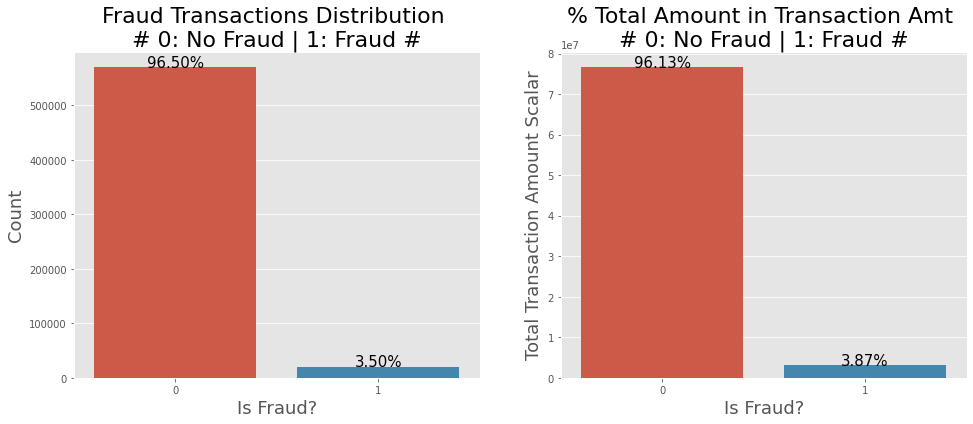

In [13]:
# checando o desbalanceamento dos dados por quantidade de transações e valor das transações
# ("TransactionAmt")
train['TransactionAmt'] = train['TransactionAmt'].astype(float)
total = len(train)
total_amt = train.groupby(['isFraud'])['TransactionAmt'].sum().sum()
plt.figure(figsize = (16, 6))

plt.subplot(121)
g = sns.countplot(x = 'isFraud', data = train, )
g.set_title("Fraud Transactions Distribution \n# 0: No Fraud | 1: Fraud #", fontsize = 22)
g.set_xlabel("Is Fraud?", fontsize = 18)
g.set_ylabel('Count', fontsize = 18)

for p in g.patches:
    height = p.get_height()
    g.text(p.get_x() + p.get_width()/2.,
          height + 3,
          '{:1.2f}%'.format(height/total * 100),
          ha = "center", fontsize = 15)

perc_amt = (train.groupby(['isFraud'])['TransactionAmt'].sum())
perc_amt = perc_amt.reset_index()
plt.subplot(122)
g1 = sns.barplot(x = 'isFraud', y = 'TransactionAmt', dodge = True, data = perc_amt)
g1.set_title("% Total Amount in Transaction Amt \n# 0: No Fraud | 1: Fraud #", fontsize = 22)
g1.set_xlabel("Is Fraud?", fontsize = 18)
g1.set_ylabel('Total Transaction Amount Scalar', fontsize = 18)
for p in g1.patches:
    height = p.get_height()
    g1.text(p.get_x() + p.get_width()/2.,
           height + 3,
           '{:1.2f}%'.format(height/total_amt * 100),
           ha = "center", fontsize = 15)

# Feature Engineering

## Convertendo "TransactionDT" em data, dias, horários e dias da semana

In [14]:
# a primeira data é 01/12/2017 e será usada o timedelta para calcular os atributos de 
# datas e horários

import datetime

START_DATE = '2017-12-01'
start_date = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
train["Date"] = train['TransactionDT'].apply(lambda x: (start_date + datetime.timedelta
                                                             (seconds = x)))

train['_Weekdays'] = train['Date'].dt.dayofweek
train['_Hours'] = train['Date'].dt.hour
train['_Days'] = train['Date'].dt.day

In [15]:
# fazendo o mesmo para base teste

START_DATE = '2017-12-01'
start_date = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
test["Date"] = test['TransactionDT'].apply(lambda x: (start_date + datetime.timedelta
                                                             (seconds = x)))

test['_Weekdays'] = test['Date'].dt.dayofweek
test['_Hours'] = test['Date'].dt.hour
test['_Days'] = test['Date'].dt.day

In [16]:
# método do Pandas para mostrar todas as linhas ao pedir para exibir um dataframe
pd.reset_option('display.max_rows')

## Equalizando nomes de colunas entre bases de treino e teste

In [17]:
# importante para seguir com ajustes na base de forma otimizada
train.columns.difference(test.columns)

Index(['id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08',
       'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16',
       'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24',
       'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32',
       'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'isFraud'],
      dtype='object')

In [18]:
# ajustar colunas de teste
test.columns = test.columns.str.replace('-', '_')

In [19]:
# checando resultado final das diferenças
train.columns.difference(test.columns)

Index(['isFraud'], dtype='object')

## Tratando Colunas com Valores Faltantes

In [20]:
# função para checar valores NaN
def NaN_percent(df, column_name):
    #me dá a posição 0 do resultado de df.shape
    row_count = df[column_name].shape[0]
    #df.count() conta os valores não vazios
    empty_values = row_count - df[column_name].count()
    return (100.0 * empty_values)/row_count

In [21]:
# lista completa de colunas com percentuais de NaNs
for i in list(train):
    #str() converte número em string
    print(i + ': ' + str(NaN_percent(train,i))+'%')

TransactionID: 0.0%
isFraud: 0.0%
TransactionDT: 0.0%
TransactionAmt: 0.0%
ProductCD: 0.0%
card1: 0.0%
card2: 1.5126833068039423%
card3: 0.26501168422122123%
card4: 0.267043722694483%
card5: 0.7212043214684865%
card6: 0.26602770345785215%
addr1: 11.12642666034477%
addr2: 11.12642666034477%
dist1: 59.6523520845328%
dist2: 93.62837403054831%
P_emaildomain: 15.99485216920107%
R_emaildomain: 76.75161716395164%
C1: 0.0%
C2: 0.0%
C3: 0.0%
C4: 0.0%
C5: 0.0%
C6: 0.0%
C7: 0.0%
C8: 0.0%
C9: 0.0%
C10: 0.0%
C11: 0.0%
C12: 0.0%
C13: 0.0%
C14: 0.0%
D1: 0.21488806854743117%
D2: 47.54919226470688%
D3: 44.514850814508755%
D4: 28.604666915026925%
D5: 52.46740271615809%
D6: 87.60676668811597%
D7: 93.40992989467267%
D8: 87.31229044603245%
D9: 87.31229044603245%
D10: 12.873302401192129%
D11: 47.29349409015477%
D12: 89.04104717715988%
D13: 89.50926270870728%
D14: 89.46946862193924%
D15: 15.090087038981272%
M1: 45.90713584177194%
M2: 45.90713584177194%
M3: 45.90713584177194%
M4: 47.658753005723575%
M5: 59.34

V316: 0.0020320384732617604%
V317: 0.0020320384732617604%
V318: 0.0020320384732617604%
V319: 0.0020320384732617604%
V320: 0.0020320384732617604%
V321: 0.0020320384732617604%
V322: 86.05496664070174%
V323: 86.05496664070174%
V324: 86.05496664070174%
V325: 86.05496664070174%
V326: 86.05496664070174%
V327: 86.05496664070174%
V328: 86.05496664070174%
V329: 86.05496664070174%
V330: 86.05496664070174%
V331: 86.05496664070174%
V332: 86.05496664070174%
V333: 86.05496664070174%
V334: 86.05496664070174%
V335: 86.05496664070174%
V336: 86.05496664070174%
V337: 86.05496664070174%
V338: 86.05496664070174%
V339: 86.05496664070174%
id_01: 75.5760829071697%
id_02: 76.14522301622245%
id_03: 88.76892335828225%
id_04: 88.76892335828225%
id_05: 76.82375452975243%
id_06: 76.82375452975243%
id_07: 99.12707013919463%
id_08: 99.12707013919463%
id_09: 87.31229044603245%
id_10: 87.31229044603245%
id_11: 76.12727334304196%
id_12: 75.5760829071697%
id_13: 78.44007179869273%
id_14: 86.4456260371863%
id_15: 76.12608

In [22]:
# identificando colunas com mais de 75% dos valores como NaN
many_null_cols_train = [col for col in train.columns if train[col].isnull().sum() / train.shape[0] > 0.75]
many_null_cols_test = [col for col in test.columns if test[col].isnull().sum() / test.shape[0] > 0.75]

## Tratando Colunas com Valores Únicos

In [23]:
# checando se existem colunas apenas com um valor
one_value_cols_train = [col for col in train.columns if train[col].nunique() <= 1]
one_value_cols_test = [col for col in test.columns if test[col].nunique() <= 1]

print(f'There are {len(one_value_cols_train)} columns in train dataset with one unique value.')
print(f'There are {len(one_value_cols_test)} columns in test dataset with one unique value.')

There are 0 columns in train dataset with one unique value.
There are 1 columns in test dataset with one unique value.


In [24]:
# identificando colunas com valor único
one_value_cols_train = [col for col in train.columns if train[col].nunique() <= 1]
one_value_cols_test = [col for col in test.columns if test[col].nunique() <= 1]

In [25]:
# checando colunas com mais de 75% de valores únicos
big_top_value_cols_train = [col for col in train.columns if \
                            train[col].value_counts(dropna=False, normalize=True).values[0] > 0.75]
big_top_value_cols_test = [col for col in test.columns if test[col].value_counts(dropna=False,\
                                                                                 normalize=True).values[0] > 0.75]

## Concatenando as Colunas Desnecessárias e Removendo-as

In [26]:
cols_to_drop = list(set(many_null_cols_train + big_top_value_cols_train + \
                        one_value_cols_train + many_null_cols_test + big_top_value_cols_test + one_value_cols_test))

# excluir a coluna 'isFraud' da remoção
cols_to_drop.remove('isFraud')
len(cols_to_drop)

346

In [27]:
train = train.drop(cols_to_drop, axis=1)
test = test.drop(cols_to_drop, axis=1)

In [28]:
# checando novamente a diferença entre colunas das bases treino e teste
train.columns.difference(test.columns)

Index(['isFraud'], dtype='object')

## Identificando Linhas com Valores Faltantes e Removendo-as

In [29]:
# checando e excluindo linhas com mais de 75% de valores faltantes
perc = 75.0 
min_count =  int(((100 - perc) / 100) * train.shape[1] + 1)
train = train.dropna(axis = 0, thresh = min_count)

min_count =  int(((100 - perc) / 100) * test.shape[1] + 1)
test = test.dropna(axis = 0, thresh = min_count)

In [30]:
train.shape

(590540, 92)

In [31]:
test.shape

(506691, 91)

## Remover colunas datetime e ID para balanceamento e redução de dimensionalidade

In [32]:
# remover TransactionID e datetime para balanceamento e redução de dimensionalidade
train = train.drop(['TransactionID', 'TransactionDT', 'Date'], axis = 1)
test = test.drop(['TransactionID', 'TransactionDT', 'Date'], axis = 1)

In [33]:
# checando por diferenças de colunas entre as bases de treino e teste
train.columns.difference(test.columns)

Index(['isFraud'], dtype='object')

## Substituindo NaNs remanescentes por média (variáveis numéricas) e moda (variáveis categóricas) para pacotes de balanceamento e redução de dimensionalidade

In [34]:
# lista completa de colunas remanescentes com percentuais de NaNs
for i in list(train):
    #str() converte número em string
    print(i + ': ' + str(NaN_percent(train,i))+'%')

isFraud: 0.0%
TransactionAmt: 0.0%
ProductCD: 0.0%
card1: 0.0%
card2: 1.5126833068039423%
card4: 0.267043722694483%
card5: 0.7212043214684865%
addr1: 11.12642666034477%
dist1: 59.6523520845328%
P_emaildomain: 15.99485216920107%
C1: 0.0%
C2: 0.0%
C5: 0.0%
C6: 0.0%
C9: 0.0%
C11: 0.0%
C13: 0.0%
C14: 0.0%
D1: 0.21488806854743117%
D2: 47.54919226470688%
D3: 44.514850814508755%
D4: 28.604666915026925%
D5: 52.46740271615809%
D10: 12.873302401192129%
D11: 47.29349409015477%
D15: 15.090087038981272%
M1: 45.90713584177194%
M2: 45.90713584177194%
M3: 45.90713584177194%
M4: 47.658753005723575%
M5: 59.34940901547736%
M6: 28.678836319300977%
M7: 58.63531682866529%
M8: 58.633115453652586%
M9: 58.633115453652586%
V1: 47.29349409015477%
V2: 47.29349409015477%
V3: 47.29349409015477%
V4: 47.29349409015477%
V5: 47.29349409015477%
V6: 47.29349409015477%
V7: 47.29349409015477%
V8: 47.29349409015477%
V9: 47.29349409015477%
V10: 47.29349409015477%
V11: 47.29349409015477%
V12: 12.881938564703491%
V13: 12.88193

In [35]:
# das colunas com NaNs remanescentes, entender quais são de variáveis numéricas ou categóricas
pd.options.display.max_rows = 999
resumetable(train)

Dataset Shape: (590540, 89)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,isFraud,int64,0,2,0,0,0,0.220000000000000
1,TransactionAmt,float64,0,20902,68.5,29.0,59.0,8.350000000000000
2,ProductCD,object,0,5,W,W,W,1.280000000000000
3,card1,int64,0,13553,13926,2755,4663,9.970000000000001
4,card2,float64,8933,500,NaN,404.0,490.0,6.320000000000000
5,card4,object,1577,4,discover,mastercard,visa,1.090000000000000
6,card5,float64,4259,119,142.0,102.0,166.0,2.660000000000000
7,addr1,float64,65706,332,315.0,325.0,330.0,5.060000000000000
8,dist1,float64,352271,2651,19.0,NaN,287.0,6.340000000000000
9,P_emaildomain,object,94456,59,NaN,gmail.com,outlook.com,2.680000000000000


In [36]:
# função para substituir os valores faltantes, usando média para variáveis numéricas e moda para variáveis categóricas
def replace_missing_values(df, numeric_strategy='mean', categorical_strategy='mode'):
    """
    Substitui valores ausentes em um DataFrame.
    
    Parâmetros:
    - df: O DataFrame contendo os dados.
    - numeric_strategy: A estratégia de substituição para colunas numéricas ('mean' ou 'median').
    - categorical_strategy: A estratégia de substituição para colunas categóricas ('mode' ou 'random').
    
    Retorna:
    - Um novo DataFrame com os valores ausentes substituídos.
    """
    df_copy = df.copy()
    
    # Lidar com colunas numéricas
    numeric_cols = df_copy.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if numeric_strategy == 'mean':
            df_copy[col].fillna(df_copy[col].mean(), inplace=True)
        elif numeric_strategy == 'median':
            df_copy[col].fillna(df_copy[col].median(), inplace=True)
    
    # Lidar com colunas categóricas
    categorical_cols = df_copy.select_dtypes(exclude=[np.number]).columns
    for col in categorical_cols:
        if categorical_strategy == 'mode':
            df_copy[col].fillna(df_copy[col].mode()[0], inplace=True)
        elif categorical_strategy == 'random':
            df_copy[col].fillna(df_copy[col].sample(1).iloc[0], inplace=True)
    
    return df_copy

In [37]:
train = replace_missing_values(train)

In [38]:
# checando mais uma vez as colunas remanescentes com percentuais de NaNs
for i in list(train):
    #str() converte número em string
    print(i + ': ' + str(NaN_percent(train,i))+'%')

isFraud: 0.0%
TransactionAmt: 0.0%
ProductCD: 0.0%
card1: 0.0%
card2: 0.0%
card4: 0.0%
card5: 0.0%
addr1: 0.0%
dist1: 0.0%
P_emaildomain: 0.0%
C1: 0.0%
C2: 0.0%
C5: 0.0%
C6: 0.0%
C9: 0.0%
C11: 0.0%
C13: 0.0%
C14: 0.0%
D1: 0.0%
D2: 0.0%
D3: 0.0%
D4: 0.0%
D5: 0.0%
D10: 0.0%
D11: 0.0%
D15: 0.0%
M1: 0.0%
M2: 0.0%
M3: 0.0%
M4: 0.0%
M5: 0.0%
M6: 0.0%
M7: 0.0%
M8: 0.0%
M9: 0.0%
V1: 0.0%
V2: 0.0%
V3: 0.0%
V4: 0.0%
V5: 0.0%
V6: 0.0%
V7: 0.0%
V8: 0.0%
V9: 0.0%
V10: 0.0%
V11: 0.0%
V12: 0.0%
V13: 0.0%
V29: 0.0%
V30: 0.0%
V35: 0.0%
V36: 0.0%
V39: 0.0%
V40: 0.0%
V42: 0.0%
V43: 0.0%
V48: 0.0%
V49: 0.0%
V50: 0.0%
V51: 0.0%
V52: 0.0%
V53: 0.0%
V54: 0.0%
V69: 0.0%
V70: 0.0%
V75: 0.0%
V76: 0.0%
V80: 0.0%
V81: 0.0%
V84: 0.0%
V85: 0.0%
V90: 0.0%
V91: 0.0%
V92: 0.0%
V93: 0.0%
V96: 0.0%
V99: 0.0%
V127: 0.0%
V130: 0.0%
V280: 0.0%
V282: 0.0%
V283: 0.0%
V285: 0.0%
V307: 0.0%
V308: 0.0%
V310: 0.0%
_Weekdays: 0.0%
_Hours: 0.0%
_Days: 0.0%


In [39]:
test = replace_missing_values(test)

In [40]:
# checando mais uma vez as colunas remanescentes com percentuais de NaNs
for i in list(test):
    #str() converte número em string
    print(i + ': ' + str(NaN_percent(test,i))+'%')

TransactionAmt: 0.0%
ProductCD: 0.0%
card1: 0.0%
card2: 0.0%
card4: 0.0%
card5: 0.0%
addr1: 0.0%
dist1: 0.0%
P_emaildomain: 0.0%
C1: 0.0%
C2: 0.0%
C5: 0.0%
C6: 0.0%
C9: 0.0%
C11: 0.0%
C13: 0.0%
C14: 0.0%
D1: 0.0%
D2: 0.0%
D3: 0.0%
D4: 0.0%
D5: 0.0%
D10: 0.0%
D11: 0.0%
D15: 0.0%
M1: 0.0%
M2: 0.0%
M3: 0.0%
M4: 0.0%
M5: 0.0%
M6: 0.0%
M7: 0.0%
M8: 0.0%
M9: 0.0%
V1: 0.0%
V2: 0.0%
V3: 0.0%
V4: 0.0%
V5: 0.0%
V6: 0.0%
V7: 0.0%
V8: 0.0%
V9: 0.0%
V10: 0.0%
V11: 0.0%
V12: 0.0%
V13: 0.0%
V29: 0.0%
V30: 0.0%
V35: 0.0%
V36: 0.0%
V39: 0.0%
V40: 0.0%
V42: 0.0%
V43: 0.0%
V48: 0.0%
V49: 0.0%
V50: 0.0%
V51: 0.0%
V52: 0.0%
V53: 0.0%
V54: 0.0%
V69: 0.0%
V70: 0.0%
V75: 0.0%
V76: 0.0%
V80: 0.0%
V81: 0.0%
V84: 0.0%
V85: 0.0%
V90: 0.0%
V91: 0.0%
V92: 0.0%
V93: 0.0%
V96: 0.0%
V99: 0.0%
V127: 0.0%
V130: 0.0%
V280: 0.0%
V282: 0.0%
V283: 0.0%
V285: 0.0%
V307: 0.0%
V308: 0.0%
V310: 0.0%
_Weekdays: 0.0%
_Hours: 0.0%
_Days: 0.0%


## Codificação de variáveis categóricas (para pacotes de redução de dimensionalidade)

In [41]:
# identificando os atributos classificados como "object" para codificação
object_columns = train.select_dtypes(include = "object").columns
print(object_columns)

Index(['ProductCD', 'card4', 'P_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5',
       'M6', 'M7', 'M8', 'M9'],
      dtype='object')


In [42]:
# pela documentação do conjunto de dados, nenhuma delas é categórica ordinal
# separando as colunas a serem tratadas
object_columns_treated = ['ProductCD', 'card4', 'P_emaildomain', 'M1', 'M2', 'M3', 'M4',
       'M5', 'M6', 'M7', 'M8', 'M9']

In [43]:
# Aplicando One-Hot Encoding em várias colunas
train = pd.get_dummies(train, columns = object_columns_treated)
test = pd.get_dummies(test, columns = object_columns_treated)

In [44]:
# realizando a transformação usando LabelEncoder
#le = LabelEncoder()
#for col in object_columns_treated:
#    if col in train.columns:
#        le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
#        train[col] = le.fit_transform(list(train[col].astype(str).values))
#        test[col] = le.fit_transform(list(test[col].astype(str).values))

In [45]:
# checando se ainda existem colunas "object"
checking_remaining_objects_train = resumetable(train)[['Name', 'dtypes']]
checking_remaining_objects_train[checking_remaining_objects_train['dtypes'] == 'object']

Dataset Shape: (590540, 164)


,Name,dtypes


In [46]:
# checando se ainda existem colunas "object"
checking_remaining_objects_test = resumetable(test)[['Name', 'dtypes']]
checking_remaining_objects_test[checking_remaining_objects_test['dtypes'] == 'object']

Dataset Shape: (506691, 164)


,Name,dtypes


In [47]:
# checando se ainda existem colunas categóricas
cols = train.columns
num_cols = train._get_numeric_data().columns
cat_cols = list(set(cols) - set(num_cols))
cat_cols

[]

In [48]:
# checando se ainda existem colunas categóricas
cols = test.columns
num_cols = test._get_numeric_data().columns
cat_cols = list(set(cols) - set(num_cols))
cat_cols

[]

In [49]:
# checando por diferenças entre as colunas de treino e teste
train.columns.difference(test.columns)

Index(['isFraud'], dtype='object')

## Checando colunas com valores negativos para métodos de seleção de atributos

In [50]:
columns_negative_values = train.columns[train.lt(0).any()]
print("Columns with negative values:", columns_negative_values)

Columns with negative values: Index(['D4', 'D11', 'D15'], dtype='object')


In [51]:
# separando as columas com valores negativos
negative_columns_treated = ['D4', 'D11', 'D15']

In [52]:
# realizando a transformação
le = LabelEncoder()
for col in negative_columns_treated:
    if col in train.columns:
        le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
        train[col] = le.fit_transform(list(train[col].astype(str).values))
        test[col] = le.fit_transform(list(test[col].astype(str).values))

In [53]:
# última checagem de valores negativos
columns_negative_values = train.columns[train.lt(0).any()]
print("Columns with negative values:", columns_negative_values)

Columns with negative values: Index([], dtype='object')


In [54]:
# última checagem de valores negativos
columns_negative_values = test.columns[test.lt(0).any()]
print("Columns with negative values:", columns_negative_values)

Columns with negative values: Index([], dtype='object')


# Separação da base de treino entre treino e teste para balanceamento e avaliação de desempenho dos algoritmos de ML

In [55]:
# proporção desejada para treino, teste e validação
proporcao_treino = 0.8
proporcao_teste = 0.1
proporcao_validacao = 0.1

In [56]:
# Separar entre treinamento e teste com estratificação (80% para treinamento, 20% para teste)
X = train.drop('isFraud',axis = 1)
y = train['isFraud'].astype('uint8')

In [57]:
# train_test_split para dividir os dados em treino e temporário
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=(1 - proporcao_treino), stratify = y)

In [58]:
# Use train_test_split novamente para dividir os dados temporários em teste e validação
proporcao_restante = proporcao_validacao / (proporcao_teste + proporcao_validacao)
X_test, X_validacao, y_test, y_validacao = train_test_split(X_temp, y_temp, test_size=proporcao_restante, stratify=y_temp)

In [59]:
# Exibir a distribuição das classes nos conjuntos de treinamento e teste
print("Distribuição das classes no conjunto de treinamento:")
print(y_train.value_counts())

print("\nDistribuição das classes no conjunto de teste:")
print(y_test.value_counts())

Distribuição das classes no conjunto de treinamento:
isFraud
0    455902
1     16530
Name: count, dtype: int64

Distribuição das classes no conjunto de teste:
isFraud
0    56987
1     2067
Name: count, dtype: int64


In [60]:
# combinando as classes minoritária com a majoritária subamostrada
test_split = pd.concat([X_test, y_test], \
                                       axis = 1, ignore_index=False)

# contando as classes minoritária e majoritária
test_split.isFraud.value_counts()

isFraud
0    56987
1     2067
Name: count, dtype: int64

# Balanceamento de Classes

### Oversampling com SMOTE

In [61]:
from imblearn.over_sampling import SMOTE

In [62]:
smote = SMOTE(random_state=42)

In [63]:
%%time
X_train_oversample_with_smote, y_train_oversample_with_smote = smote.fit_resample(X_train, y_train)

CPU times: user 6.57 s, sys: 897 ms, total: 7.47 s
Wall time: 2.64 s


In [64]:
# combinando as classes majoritária com a minoritária sobreamostrada 
train_oversample_with_smote = pd.concat([X_train_oversample_with_smote, y_train_oversample_with_smote], \
                                        axis = 1, ignore_index=False)

# contando as classes minoritária e majoritária
train_oversample_with_smote.isFraud.value_counts()

isFraud
0    455902
1    455902
Name: count, dtype: int64

### Oversampling com AdaSyn

In [65]:
from imblearn.over_sampling import ADASYN

In [66]:
adasyn = ADASYN(random_state=42)

In [67]:
%%time
X_train_oversample_with_adasyn, y_train_oversample_with_adasyn = adasyn.fit_resample(X_train, y_train)

CPU times: user 2min 5s, sys: 408 ms, total: 2min 5s
Wall time: 13.3 s


In [68]:
# combinando as classes majoritária com a minoritária sobreamostrada 
train_oversample_with_adasyn = pd.concat([X_train_oversample_with_adasyn, \
                                                    y_train_oversample_with_adasyn], \
                                        axis = 1, ignore_index=False)

# contando as classes minoritária e majoritária
train_oversample_with_adasyn.isFraud.value_counts()

isFraud
1    456728
0    455902
Name: count, dtype: int64

In [69]:
t1 = time.time()
print("Script took {:.2} s".format(t1 - t0))

Script took 9.3e+01 s


# Redução de Dimensionalidade

## Seleção de Atributos com Teste do Qui-Quadrado

In [70]:
# importando as bibliotecas necessárias
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

### Oversampling com SMOTE

In [71]:
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train') 
model_100_chi2 = SelectKBest(chi2, k = 75)
new_100_chi2 = model_100_chi2.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)
X_train_oversample_with_smote_100_chi2 = new_100_chi2.transform(X_train_oversample_with_smote)

# transformando os atributos selecionados em dataframe 
cols = new_100_chi2.get_support(indices = True)
features_df_new_100_chi2 = X_train_oversample_with_smote.iloc[:, cols]

In [72]:
oversample_with_smote_cols_100_chi2 = features_df_new_100_chi2.columns

In [73]:
oversample_with_smote_cols_100_chi2

Index(['TransactionAmt', 'card1', 'card2', 'card5', 'dist1', 'C1', 'C2', 'C5',
       'C6', 'C9', 'C11', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D10',
       'D11', 'D15', 'V12', 'V13', 'V29', 'V30', 'V35', 'V36', 'V39', 'V40',
       'V42', 'V43', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V69', 'V70',
       'V75', 'V76', 'V80', 'V81', 'V84', 'V85', 'V90', 'V91', 'V92', 'V93',
       'V96', 'V99', 'V127', 'V130', 'V282', 'V283', 'V285', 'V307', 'V308',
       'V310', '_Weekdays', '_Hours', 'ProductCD_C', 'ProductCD_H',
       'ProductCD_R', 'ProductCD_S', 'ProductCD_W', 'card4_discover',
       'P_emaildomain_gmail.com', 'P_emaildomain_hotmail.com',
       'P_emaildomain_outlook.com', 'M4_M0', 'M4_M2', 'M5_T', 'M6_F', 'M6_T'],
      dtype='object')

### Oversampling com AdaSyn

In [74]:
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train') 
model_100_chi2 = SelectKBest(chi2, k = 75)
new_100_chi2 = model_100_chi2.fit(X_train_oversample_with_adasyn, y_train_oversample_with_adasyn)
X_train_oversample_with_adasyn_100_chi2 = new_100_chi2.transform(X_train_oversample_with_adasyn)

# transformando os atributos selecionados em dataframe 
cols = new_100_chi2.get_support(indices = True)
features_df_new_100_chi2 = X_train_oversample_with_adasyn.iloc[:, cols]

In [75]:
oversample_with_adasyn_cols_100_chi2 = features_df_new_100_chi2.columns

In [76]:
oversample_with_adasyn_cols_100_chi2

Index(['TransactionAmt', 'card1', 'card2', 'card5', 'dist1', 'C1', 'C2', 'C5',
       'C6', 'C9', 'C11', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D10',
       'D11', 'D15', 'V12', 'V13', 'V29', 'V30', 'V35', 'V36', 'V39', 'V40',
       'V42', 'V43', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V69', 'V70',
       'V75', 'V80', 'V81', 'V84', 'V85', 'V90', 'V91', 'V92', 'V93', 'V96',
       'V99', 'V127', 'V130', 'V280', 'V282', 'V283', 'V285', 'V307', 'V308',
       'V310', '_Weekdays', '_Hours', 'ProductCD_C', 'ProductCD_H',
       'ProductCD_R', 'ProductCD_S', 'ProductCD_W', 'card4_discover',
       'card4_mastercard', 'P_emaildomain_gmail.com',
       'P_emaildomain_hotmail.com', 'P_emaildomain_outlook.com', 'M4_M2',
       'M5_T', 'M6_F', 'M6_T'],
      dtype='object')

# Seleção do Modelo de Classificação

## Inicializando os classificadores

In [77]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import cross_validate

In [78]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score

In [79]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

In [80]:
clf_et = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf_dt = DecisionTreeClassifier(random_state=0)
clf_cb = CatBoostClassifier(iterations=5, learning_rate=0.1) # loss_function='CrossEntropy')
clf_gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
clf_ada = AdaBoostClassifier(n_estimators=100, random_state=0)
clf_knn = KNeighborsClassifier(n_neighbors=3)

## Validação Cruzada para Oversampling com SMOTE

### 75 Chi-Square

In [81]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_smote[oversample_with_smote_cols_100_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test[oversample_with_smote_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de treino
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de treino
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_et.predict_proba(X_test[oversample_with_smote_cols_100_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 2min 55s, sys: 209 ms, total: 2min 55s
Wall time: 2min 55s


Metrics,F1_score Positivo,F1_score Negativo
Original,0.658220388921626,0.989887895113064
Threshold: 0.05,0.244332324251598,0.89119843476071
Threshold: 0.1,0.386837881219904,0.951108917046057
Threshold: 0.15,0.499451668494438,0.971402998433654
Threshold: 0.2,0.576952526799387,0.980422380496793
Threshold: 0.25,0.628038194444444,0.984898678414097
Threshold: 0.3,0.660462896683369,0.987508449134018
Threshold: 0.35,0.671246819338422,0.988684334985724
Threshold: 0.4,0.680828179618177,0.989623128097982
Threshold: 0.45,0.674333800841515,0.989864068515754


In [82]:
%%time

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_validacao[oversample_with_smote_cols_100_chi2], \
                                   y_validacao, cv = stratified_kfold, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_validacao[oversample_with_smote_cols_100_chi2], \
                                   y_validacao, cv = stratified_kfold, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

F1-Score Positivo (Teste): 0.6582203889216265
F1-Score Negativo (Teste): 0.9898878951130639
F1-Score Positivo Médio (Validação Cruzada): 0.4570163368378354
F1-Score Positivo Fold 1: 0.4326241134751772
F1-Score Positivo Fold 2: 0.42028985507246375
F1-Score Positivo Fold 3: 0.45936395759717313
F1-Score Positivo Fold 4: 0.471830985915493
F1-Score Positivo Fold 5: 0.46478873239436624
F1-Score Positivo Fold 6: 0.4542124542124542
F1-Score Positivo Fold 7: 0.5159010600706714
F1-Score Positivo Fold 8: 0.4545454545454546
F1-Score Positivo Fold 9: 0.43065693430656926
F1-Score Positivo Fold 10: 0.46594982078853053
F1-Score Negativo Médio (Validação Cruzada): 0.9868001627019961
F1-Score Negativo Fold 1: 0.9861231569817867
F1-Score Negativo Fold 2: 0.9861303744798889
F1-Score Negativo Fold 3: 0.9867291178766588
F1-Score Negativo Fold 4: 0.9869882026370576
F1-Score Negativo Fold 5: 0.9868124240846781
F1-Score Negativo Fold 6: 0.9870850307705643
F1-Score Negativo Fold 7: 0.98811486076169
F1-Score Neg

In [83]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_smote[oversample_with_smote_cols_100_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test[oversample_with_smote_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de treino
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de treino
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_dt.predict_proba(X_test[oversample_with_smote_cols_100_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 31.5 s, sys: 52 ms, total: 31.6 s
Wall time: 31.6 s


Metrics,F1_score Positivo,F1_score Negativo
Original,0.475154617189166,0.97830169548312
Threshold: 0.05,0.474850809889173,0.97827467024053
Threshold: 0.1,0.474850809889173,0.97827467024053
Threshold: 0.15,0.474850809889173,0.97827467024053
Threshold: 0.2,0.474850809889173,0.97827467024053
Threshold: 0.25,0.474850809889173,0.97827467024053
Threshold: 0.3,0.474850809889173,0.97827467024053
Threshold: 0.35,0.474952035813259,0.978283678813582
Threshold: 0.4,0.474952035813259,0.978283678813582
Threshold: 0.45,0.474952035813259,0.978283678813582


In [84]:
%%time

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_validacao[oversample_with_smote_cols_100_chi2], \
                                   y_validacao, cv = stratified_kfold, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_validacao[oversample_with_smote_cols_100_chi2], \
                                   y_validacao, cv = stratified_kfold, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

F1-Score Positivo (Teste): 0.47515461718916613
F1-Score Negativo (Teste): 0.9783016954831201
F1-Score Positivo Médio (Validação Cruzada): 0.37371147935660387
F1-Score Positivo Fold 1: 0.35079726651480636
F1-Score Positivo Fold 2: 0.3146067415730337
F1-Score Positivo Fold 3: 0.3413566739606127
F1-Score Positivo Fold 4: 0.4260869565217391
F1-Score Positivo Fold 5: 0.4070796460176991
F1-Score Positivo Fold 6: 0.3879907621247113
F1-Score Positivo Fold 7: 0.35697940503432496
F1-Score Positivo Fold 8: 0.40265486725663724
F1-Score Positivo Fold 9: 0.35604395604395606
F1-Score Positivo Fold 10: 0.3935185185185185
F1-Score Negativo Médio (Validação Cruzada): 0.9754146383225475
F1-Score Negativo Fold 1: 0.9749406489053021
F1-Score Negativo Fold 2: 0.9731679422890824
F1-Score Negativo Fold 3: 0.9734918538088947
F1-Score Negativo Fold 4: 0.9767441860465117
F1-Score Negativo Fold 5: 0.9764042965310795
F1-Score Negativo Fold 6: 0.9767073921068823
F1-Score Negativo Fold 7: 0.9752923590961047
F1-Score

In [85]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_smote[oversample_with_smote_cols_100_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_cb.predict(X_test[oversample_with_smote_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de treino
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de treino
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_cb.predict_proba(X_test[oversample_with_smote_cols_100_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

0:	learn: 0.6192307	total: 129ms	remaining: 515ms
1:	learn: 0.5525056	total: 215ms	remaining: 323ms
2:	learn: 0.5109586	total: 279ms	remaining: 186ms
3:	learn: 0.4698178	total: 344ms	remaining: 86ms
4:	learn: 0.4332311	total: 408ms	remaining: 0us
CPU times: user 14 s, sys: 162 ms, total: 14.2 s
Wall time: 7.99 s


Metrics,F1_score Positivo,F1_score Negativo
Original,0.240701754385965,0.91888143344454
Threshold: 0.05,0.067636327939661,0.0
Threshold: 0.1,0.067636327939661,0.0
Threshold: 0.15,0.067636327939661,0.0
Threshold: 0.2,0.068077398106217,0.013801997107157
Threshold: 0.25,0.075620957915456,0.238593023794451
Threshold: 0.3,0.095834060482162,0.535020577714527
Threshold: 0.35,0.131998818141528,0.741827049828632
Threshold: 0.4,0.161490683229814,0.822769230769231
Threshold: 0.45,0.194177231318086,0.876487877278808


In [86]:
%%time

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_validacao[oversample_with_smote_cols_100_chi2], \
                                   y_validacao, cv = stratified_kfold, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_validacao[oversample_with_smote_cols_100_chi2], \
                                   y_validacao, cv = stratified_kfold, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

0:	learn: 0.5472211	total: 6.88ms	remaining: 27.5ms
1:	learn: 0.4284612	total: 13.2ms	remaining: 19.9ms
2:	learn: 0.3544768	total: 20ms	remaining: 13.3ms
3:	learn: 0.2987072	total: 26.6ms	remaining: 6.65ms
4:	learn: 0.2608299	total: 32.1ms	remaining: 0us
0:	learn: 0.5473898	total: 4.54ms	remaining: 18.2ms
1:	learn: 0.4295192	total: 8.7ms	remaining: 13.1ms
2:	learn: 0.3554615	total: 13.2ms	remaining: 8.79ms
3:	learn: 0.2995549	total: 17.8ms	remaining: 4.45ms
4:	learn: 0.2615712	total: 22.3ms	remaining: 0us
0:	learn: 0.5471496	total: 4.98ms	remaining: 19.9ms
1:	learn: 0.4311953	total: 10.5ms	remaining: 15.8ms
2:	learn: 0.3432410	total: 16.4ms	remaining: 10.9ms
3:	learn: 0.2892153	total: 21.7ms	remaining: 5.43ms
4:	learn: 0.2516549	total: 26.8ms	remaining: 0us
0:	learn: 0.5469855	total: 16.1ms	remaining: 64.5ms
1:	learn: 0.4288555	total: 26.4ms	remaining: 39.7ms
2:	learn: 0.3463913	total: 34.7ms	remaining: 23.1ms
3:	learn: 0.2856973	total: 41.3ms	remaining: 10.3ms
4:	learn: 0.2445482	tota

In [87]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_smote[oversample_with_smote_cols_100_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_gbc.predict(X_test[oversample_with_smote_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de treino
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de treino
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_gbc.predict_proba(X_test[oversample_with_smote_cols_100_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 3min 17s, sys: 70.3 ms, total: 3min 17s
Wall time: 3min 17s


Metrics,F1_score Positivo,F1_score Negativo
Original,0.303436475117639,0.956028624150502
Threshold: 0.05,0.100538790243385,0.578657482811354
Threshold: 0.1,0.128718386749359,0.742698588521732
Threshold: 0.15,0.152738980161924,0.815490735871818
Threshold: 0.2,0.178120947777909,0.862134424868007
Threshold: 0.25,0.199972012314582,0.889862834245203
Threshold: 0.3,0.222589713907723,0.911313600090554
Threshold: 0.35,0.244482824793706,0.926880002971603
Threshold: 0.4,0.26922652543308,0.939263606767848
Threshold: 0.45,0.288308740068104,0.948783343468356


In [88]:
%%time

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_validacao[oversample_with_smote_cols_100_chi2], \
                                   y_validacao, cv = stratified_kfold, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_validacao[oversample_with_smote_cols_100_chi2], \
                                   y_validacao, cv = stratified_kfold, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

F1-Score Positivo (Teste): 0.3034364751176387
F1-Score Negativo (Teste): 0.9560286241505018
F1-Score Positivo Médio (Validação Cruzada): 0.3064272003083047
F1-Score Positivo Fold 1: 0.36101083032490977
F1-Score Positivo Fold 2: 0.13617021276595742
F1-Score Positivo Fold 3: 0.3041825095057034
F1-Score Positivo Fold 4: 0.3731343283582089
F1-Score Positivo Fold 5: 0.39259259259259255
F1-Score Positivo Fold 6: 0.3320463320463321
F1-Score Positivo Fold 7: 0.38235294117647056
F1-Score Positivo Fold 8: 0.12280701754385966
F1-Score Positivo Fold 9: 0.3190661478599222
F1-Score Positivo Fold 10: 0.3409090909090909
F1-Score Negativo Médio (Validação Cruzada): 0.9845487098307443
F1-Score Negativo Fold 1: 0.9846553966189857
F1-Score Negativo Fold 2: 0.982465232789151
F1-Score Negativo Fold 3: 0.9841544722486796
F1-Score Negativo Fold 4: 0.9854469854469854
F1-Score Negativo Fold 5: 0.9857885615251301
F1-Score Negativo Fold 6: 0.9850229417366463
F1-Score Negativo Fold 7: 0.9854394175767031
F1-Score N

In [89]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_smote[oversample_with_smote_cols_100_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_ada.predict(X_test[oversample_with_smote_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de treino
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de treino
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_ada.predict_proba(X_test[oversample_with_smote_cols_100_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 3min 56s, sys: 3.59 s, total: 4min
Wall time: 4min


Metrics,F1_score Positivo,F1_score Negativo
Original,0.295675675675676,0.952921198106731
Threshold: 0.05,0.067636327939661,0.0
Threshold: 0.1,0.067636327939661,0.0
Threshold: 0.15,0.067636327939661,0.0
Threshold: 0.2,0.067636327939661,0.0
Threshold: 0.25,0.067636327939661,0.0
Threshold: 0.3,0.067636327939661,0.0
Threshold: 0.35,0.067636327939661,0.0
Threshold: 0.4,0.067636327939661,0.0
Threshold: 0.45,0.067636327939661,0.0


In [90]:
%%time

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_validacao[oversample_with_smote_cols_100_chi2], \
                                   y_validacao, cv = stratified_kfold, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_validacao[oversample_with_smote_cols_100_chi2], \
                                   y_validacao, cv = stratified_kfold, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

F1-Score Positivo (Teste): 0.2956756756756757
F1-Score Negativo (Teste): 0.9529211981067313
F1-Score Positivo Médio (Validação Cruzada): 0.32079751350346963
F1-Score Positivo Fold 1: 0.3490909090909091
F1-Score Positivo Fold 2: 0.3134328358208955
F1-Score Positivo Fold 3: 0.29885057471264365
F1-Score Positivo Fold 4: 0.34220532319391633
F1-Score Positivo Fold 5: 0.3397683397683398
F1-Score Positivo Fold 6: 0.25806451612903225
F1-Score Positivo Fold 7: 0.3333333333333333
F1-Score Positivo Fold 8: 0.3582089552238806
F1-Score Positivo Fold 9: 0.31698113207547174
F1-Score Positivo Fold 10: 0.2980392156862745
F1-Score Negativo Médio (Validação Cruzada): 0.9845690751597516
F1-Score Negativo Fold 1: 0.9844847013955101
F1-Score Negativo Fold 2: 0.9840609840609841
F1-Score Negativo Fold 3: 0.9841572158254697
F1-Score Negativo Fold 4: 0.985020348082085
F1-Score Negativo Fold 5: 0.9851960869188814
F1-Score Negativo Fold 6: 0.9840857983047916
F1-Score Negativo Fold 7: 0.9847566256712281
F1-Score N

In [91]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_smote[oversample_with_smote_cols_100_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_knn.predict(X_test[oversample_with_smote_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de treino
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de treino
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_knn.predict_proba(X_test[oversample_with_smote_cols_100_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 2h 27min 27s, sys: 736 ms, total: 2h 27min 28s
Wall time: 12min 37s


Metrics,F1_score Positivo,F1_score Negativo
Original,0.327365045430251,0.95449450390512
Threshold: 0.05,0.266997518610422,0.931641257763831
Threshold: 0.1,0.266997518610422,0.931641257763831
Threshold: 0.15,0.266997518610422,0.931641257763831
Threshold: 0.2,0.266997518610422,0.931641257763831
Threshold: 0.25,0.266997518610422,0.931641257763831
Threshold: 0.3,0.266997518610422,0.931641257763831
Threshold: 0.35,0.327365045430251,0.95449450390512
Threshold: 0.4,0.327365045430251,0.95449450390512
Threshold: 0.45,0.327365045430251,0.95449450390512


In [92]:
%%time

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_validacao[oversample_with_smote_cols_100_chi2], \
                                   y_validacao, cv = stratified_kfold, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_validacao[oversample_with_smote_cols_100_chi2], \
                                   y_validacao, cv = stratified_kfold, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

F1-Score Positivo (Teste): 0.32736504543025124
F1-Score Negativo (Teste): 0.95449450390512
F1-Score Positivo Médio (Validação Cruzada): 0.22595587936755734
F1-Score Positivo Fold 1: 0.17204301075268816
F1-Score Positivo Fold 2: 0.2167832167832168
F1-Score Positivo Fold 3: 0.22456140350877188
F1-Score Positivo Fold 4: 0.26936026936026936
F1-Score Positivo Fold 5: 0.24742268041237114
F1-Score Positivo Fold 6: 0.223826714801444
F1-Score Positivo Fold 7: 0.2629757785467128
F1-Score Positivo Fold 8: 0.22302158273381295
F1-Score Positivo Fold 9: 0.2078853046594982
F1-Score Positivo Fold 10: 0.21167883211678834
F1-Score Negativo Médio (Validação Cruzada): 0.9809756420801989
F1-Score Negativo Fold 1: 0.9799705193791727
F1-Score Negativo Fold 2: 0.980565677598473
F1-Score Negativo Fold 3: 0.9808276221046238
F1-Score Negativo Fold 4: 0.9811550151975684
F1-Score Negativo Fold 5: 0.9809879329802934
F1-Score Negativo Fold 6: 0.9813578427122172
F1-Score Negativo Fold 7: 0.9815120215259092
F1-Score N

### Todas as colunas

In [93]:
#reinicializando os classificadores

clf_et = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf_dt = DecisionTreeClassifier(random_state=0)
clf_cb = CatBoostClassifier(iterations=5, learning_rate=0.1) # loss_function='CrossEntropy')
clf_gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
clf_ada = AdaBoostClassifier(n_estimators=100, random_state=0)
clf_knn = KNeighborsClassifier(n_neighbors=3)

In [94]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de treino
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de treino
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_et.predict_proba(X_test)[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 3min 43s, sys: 48 ms, total: 3min 43s
Wall time: 3min 43s


Metrics,F1_score Positivo,F1_score Negativo
Original,0.660980810234542,0.990306988896146
Threshold: 0.05,0.275092376140563,0.908314019475999
Threshold: 0.1,0.441660140955364,0.961266139108705
Threshold: 0.15,0.561872909698997,0.977861189927686
Threshold: 0.2,0.635086983860826,0.984638732276309
Threshold: 0.25,0.673531476714252,0.987745421004085
Threshold: 0.3,0.688631790744467,0.989152910664844
Threshold: 0.35,0.697340425531915,0.990047923881485
Threshold: 0.4,0.685938815604827,0.990230913614737
Threshold: 0.45,0.677729257641921,0.990346463422078


In [95]:
%%time

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_validacao, \
                                   y_validacao, cv = stratified_kfold, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_validacao, \
                                   y_validacao, cv = stratified_kfold, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

F1-Score Positivo (Teste): 0.6609808102345416
F1-Score Negativo (Teste): 0.9903069888961463
F1-Score Positivo Médio (Validação Cruzada): 0.4375282528428935
F1-Score Positivo Fold 1: 0.4363636363636364
F1-Score Positivo Fold 2: 0.39097744360902253
F1-Score Positivo Fold 3: 0.45818181818181825
F1-Score Positivo Fold 4: 0.45487364620938636
F1-Score Positivo Fold 5: 0.45323741007194235
F1-Score Positivo Fold 6: 0.4030418250950571
F1-Score Positivo Fold 7: 0.45255474452554745
F1-Score Positivo Fold 8: 0.4631578947368421
F1-Score Positivo Fold 9: 0.41198501872659177
F1-Score Positivo Fold 10: 0.4509090909090909
F1-Score Negativo Médio (Validação Cruzada): 0.9866781076265283
F1-Score Negativo Fold 1: 0.9865649648955535
F1-Score Negativo Fold 2: 0.9859691668110169
F1-Score Negativo Fold 3: 0.9870850307705643
F1-Score Negativo Fold 4: 0.98690940615518
F1-Score Negativo Fold 5: 0.986819285466528
F1-Score Negativo Fold 6: 0.9864033948211657
F1-Score Negativo Fold 7: 0.9869972260748962
F1-Score Ne

In [96]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de treino
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de treino
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_dt.predict_proba(X_test)[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 45 s, sys: 64 ms, total: 45.1 s
Wall time: 45.1 s


Metrics,F1_score Positivo,F1_score Negativo
Original,0.465478841870824,0.978876586456371
Threshold: 0.05,0.465478841870824,0.978876586456371
Threshold: 0.1,0.465478841870824,0.978876586456371
Threshold: 0.15,0.465478841870824,0.978876586456371
Threshold: 0.2,0.465478841870824,0.978876586456371
Threshold: 0.25,0.465478841870824,0.978876586456371
Threshold: 0.3,0.465478841870824,0.978876586456371
Threshold: 0.35,0.465478841870824,0.978876586456371
Threshold: 0.4,0.465478841870824,0.978876586456371
Threshold: 0.45,0.465478841870824,0.978876586456371


In [97]:
%%time

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_validacao, \
                                   y_validacao, cv = stratified_kfold, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_validacao, \
                                   y_validacao, cv = stratified_kfold, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

F1-Score Positivo (Teste): 0.46547884187082406
F1-Score Negativo (Teste): 0.9788765864563714
F1-Score Positivo Médio (Validação Cruzada): 0.3774377924604343
F1-Score Positivo Fold 1: 0.3835616438356165
F1-Score Positivo Fold 2: 0.3262411347517731
F1-Score Positivo Fold 3: 0.38216560509554137
F1-Score Positivo Fold 4: 0.3912087912087912
F1-Score Positivo Fold 5: 0.41441441441441446
F1-Score Positivo Fold 6: 0.37587006960556846
F1-Score Positivo Fold 7: 0.35862068965517246
F1-Score Positivo Fold 8: 0.4054054054054054
F1-Score Positivo Fold 9: 0.3578947368421053
F1-Score Positivo Fold 10: 0.3789954337899544
F1-Score Negativo Médio (Validação Cruzada): 0.9756092020784827
F1-Score Negativo Fold 1: 0.9762616493757694
F1-Score Negativo Fold 2: 0.9749758538941083
F1-Score Negativo Fold 3: 0.9743408870469976
F1-Score Negativo Fold 4: 0.975609756097561
F1-Score Negativo Fold 5: 0.9771247580503255
F1-Score Negativo Fold 6: 0.9763599613322788
F1-Score Negativo Fold 7: 0.9754725274725276
F1-Score N

In [98]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_cb.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de treino
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de treino
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_cb.predict_proba(X_test)[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

0:	learn: 0.6056997	total: 77.5ms	remaining: 310ms
1:	learn: 0.5388929	total: 154ms	remaining: 231ms
2:	learn: 0.4822904	total: 228ms	remaining: 152ms
3:	learn: 0.4458128	total: 300ms	remaining: 75ms
4:	learn: 0.4126456	total: 370ms	remaining: 0us
CPU times: user 49.2 s, sys: 184 ms, total: 49.3 s
Wall time: 40.9 s


Metrics,F1_score Positivo,F1_score Negativo
Original,0.222277972905168,0.91238813000471
Threshold: 0.05,0.067636327939661,0.0
Threshold: 0.1,0.067636327939661,0.0
Threshold: 0.15,0.067636327939661,0.0
Threshold: 0.2,0.067636327939661,0.0
Threshold: 0.25,0.071603072218219,0.137034193200569
Threshold: 0.3,0.087539079946405,0.44277765655684
Threshold: 0.35,0.146192544180247,0.790650599361103
Threshold: 0.4,0.18467958271237,0.865029161280136
Threshold: 0.45,0.200489329889901,0.886221637619204


In [99]:
%%time

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_validacao, \
                                   y_validacao, cv = stratified_kfold, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_validacao, \
                                   y_validacao, cv = stratified_kfold, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

0:	learn: 0.5427896	total: 5.95ms	remaining: 23.8ms
1:	learn: 0.4299222	total: 11.4ms	remaining: 17ms
2:	learn: 0.3532368	total: 16.8ms	remaining: 11.2ms
3:	learn: 0.2960718	total: 22.1ms	remaining: 5.52ms
4:	learn: 0.2515307	total: 27.9ms	remaining: 0us
0:	learn: 0.5431492	total: 5.64ms	remaining: 22.6ms
1:	learn: 0.4300541	total: 10.8ms	remaining: 16.1ms
2:	learn: 0.3534669	total: 15.9ms	remaining: 10.6ms
3:	learn: 0.2963005	total: 21ms	remaining: 5.24ms
4:	learn: 0.2518577	total: 27ms	remaining: 0us
0:	learn: 0.5423180	total: 15.2ms	remaining: 60.6ms
1:	learn: 0.4292091	total: 24.8ms	remaining: 37.3ms
2:	learn: 0.3525571	total: 32.1ms	remaining: 21.4ms
3:	learn: 0.2954624	total: 38.1ms	remaining: 9.52ms
4:	learn: 0.2509882	total: 44.3ms	remaining: 0us
0:	learn: 0.5430898	total: 5.91ms	remaining: 23.6ms
1:	learn: 0.4302759	total: 11.4ms	remaining: 17.1ms
2:	learn: 0.3536236	total: 16.9ms	remaining: 11.3ms
3:	learn: 0.2964132	total: 22.2ms	remaining: 5.56ms
4:	learn: 0.2518545	total: 

In [100]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_gbc.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de treino
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de treino
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_gbc.predict_proba(X_test)[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 4min 18s, sys: 52 ms, total: 4min 18s
Wall time: 4min 18s


Metrics,F1_score Positivo,F1_score Negativo
Original,0.32481580184982,0.96145136893734
Threshold: 0.05,0.099244478374181,0.572933438174761
Threshold: 0.1,0.129631711063654,0.745878775282497
Threshold: 0.15,0.159132910444034,0.828366654092795
Threshold: 0.2,0.187315726742362,0.873197803596073
Threshold: 0.25,0.211023622047244,0.899582907810218
Threshold: 0.3,0.237629097440503,0.920643526871267
Threshold: 0.35,0.25801749271137,0.93432500184325
Threshold: 0.4,0.282962071041541,0.945766509111773
Threshold: 0.45,0.299162892822835,0.953916676442191


In [101]:
%%time

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_validacao, \
                                   y_validacao, cv = stratified_kfold, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_validacao, \
                                   y_validacao, cv = stratified_kfold, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

F1-Score Positivo (Teste): 0.32481580184981973
F1-Score Negativo (Teste): 0.9614513689373395
F1-Score Positivo Médio (Validação Cruzada): 0.30610208659854277
F1-Score Positivo Fold 1: 0.3719298245614035
F1-Score Positivo Fold 2: 0.13617021276595742
F1-Score Positivo Fold 3: 0.30943396226415093
F1-Score Positivo Fold 4: 0.3759398496240602
F1-Score Positivo Fold 5: 0.3656716417910448
F1-Score Positivo Fold 6: 0.3384615384615384
F1-Score Positivo Fold 7: 0.3656716417910448
F1-Score Positivo Fold 8: 0.12280701754385966
F1-Score Positivo Fold 9: 0.3153846153846154
F1-Score Positivo Fold 10: 0.3595505617977528
F1-Score Negativo Médio (Validação Cruzada): 0.9844867917287733
F1-Score Negativo Fold 1: 0.984471241433157
F1-Score Negativo Fold 2: 0.982465232789151
F1-Score Negativo Fold 3: 0.9841517277214861
F1-Score Negativo Fold 4: 0.985622726485363
F1-Score Negativo Fold 5: 0.9852711835037256
F1-Score Negativo Fold 6: 0.985108225108225
F1-Score Negativo Fold 7: 0.9852711835037256
F1-Score Nega

In [102]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_ada.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de treino
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de treino
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_ada.predict_proba(X_test)[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 5min 19s, sys: 8.07 s, total: 5min 27s
Wall time: 5min 27s


Metrics,F1_score Positivo,F1_score Negativo
Original,0.316221765913758,0.958109443795489
Threshold: 0.05,0.067636327939661,0.0
Threshold: 0.1,0.067636327939661,0.0
Threshold: 0.15,0.067636327939661,0.0
Threshold: 0.2,0.067636327939661,0.0
Threshold: 0.25,0.067636327939661,0.0
Threshold: 0.3,0.067636327939661,0.0
Threshold: 0.35,0.067636327939661,0.0
Threshold: 0.4,0.067636327939661,0.0
Threshold: 0.45,0.067636327939661,0.0


In [103]:
%%time

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_validacao, \
                                   y_validacao, cv = stratified_kfold, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_validacao, \
                                   y_validacao, cv = stratified_kfold, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

F1-Score Positivo (Teste): 0.3162217659137577
F1-Score Negativo (Teste): 0.9581094437954892
F1-Score Positivo Médio (Validação Cruzada): 0.3240414199012356
F1-Score Positivo Fold 1: 0.36496350364963503
F1-Score Positivo Fold 2: 0.31007751937984496
F1-Score Positivo Fold 3: 0.31698113207547174
F1-Score Positivo Fold 4: 0.3371647509578544
F1-Score Positivo Fold 5: 0.34716981132075475
F1-Score Positivo Fold 6: 0.25203252032520324
F1-Score Positivo Fold 7: 0.3396226415094339
F1-Score Positivo Fold 8: 0.34200743494423796
F1-Score Positivo Fold 9: 0.3233082706766917
F1-Score Positivo Fold 10: 0.30708661417322836
F1-Score Negativo Médio (Validação Cruzada): 0.9846647658040478
F1-Score Negativo Fold 1: 0.984919396775871
F1-Score Negativo Fold 2: 0.984594079972304
F1-Score Negativo Fold 3: 0.9843249328829998
F1-Score Negativo Fold 4: 0.9850229417366463
F1-Score Negativo Fold 5: 0.9850151580770897
F1-Score Negativo Fold 6: 0.9840885506745071
F1-Score Negativo Fold 7: 0.9848419229103507
F1-Score 

In [104]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_knn.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de treino
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de treino
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_knn.predict_proba(X_test)[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 4h 18min 19s, sys: 1.05 s, total: 4h 18min 20s
Wall time: 22min 3s


Metrics,F1_score Positivo,F1_score Negativo
Original,0.327881930594336,0.954289383019704
Threshold: 0.05,0.268659671352207,0.931596392792993
Threshold: 0.1,0.268659671352207,0.931596392792993
Threshold: 0.15,0.268659671352207,0.931596392792993
Threshold: 0.2,0.268659671352207,0.931596392792993
Threshold: 0.25,0.268659671352207,0.931596392792993
Threshold: 0.3,0.268659671352207,0.931596392792993
Threshold: 0.35,0.327881930594336,0.954289383019704
Threshold: 0.4,0.327881930594336,0.954289383019704
Threshold: 0.45,0.327881930594336,0.954289383019704


In [105]:
%%time

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_validacao, \
                                   y_validacao, cv = stratified_kfold, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_validacao, \
                                   y_validacao, cv = stratified_kfold, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

F1-Score Positivo (Teste): 0.32788193059433585
F1-Score Negativo (Teste): 0.954289383019704
F1-Score Positivo Médio (Validação Cruzada): 0.22558487740023056
F1-Score Positivo Fold 1: 0.1956521739130435
F1-Score Positivo Fold 2: 0.20761245674740486
F1-Score Positivo Fold 3: 0.23448275862068962
F1-Score Positivo Fold 4: 0.26174496644295303
F1-Score Positivo Fold 5: 0.23611111111111113
F1-Score Positivo Fold 6: 0.2097902097902098
F1-Score Positivo Fold 7: 0.24561403508771934
F1-Score Positivo Fold 8: 0.20477815699658702
F1-Score Positivo Fold 9: 0.2402826855123675
F1-Score Positivo Fold 10: 0.21978021978021978
F1-Score Negativo Médio (Validação Cruzada): 0.980780252219534
F1-Score Negativo Fold 1: 0.9807558945908461
F1-Score Negativo Fold 2: 0.9801267031155082
F1-Score Negativo Fold 3: 0.9807325117167158
F1-Score Negativo Fold 4: 0.9808928261247177
F1-Score Negativo Fold 5: 0.9809060926922409
F1-Score Negativo Fold 6: 0.9803887539048941
F1-Score Negativo Fold 7: 0.9813449023861172
F1-Scor

## Validação Cruzada para Oversample com AdaSyn

### 75 Chi-Square

In [106]:
#reinicializando os classificadores

clf_et = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf_dt = DecisionTreeClassifier(random_state=0)
clf_cb = CatBoostClassifier(iterations=5, learning_rate=0.1) # loss_function='CrossEntropy')
clf_gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
clf_ada = AdaBoostClassifier(n_estimators=100, random_state=0)
clf_knn = KNeighborsClassifier(n_neighbors=3)

In [107]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_100_chi2], \
            y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test[oversample_with_adasyn_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de treino
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de treino
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_et.predict_proba(X_test[oversample_with_adasyn_cols_100_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 2min 29s, sys: 56 ms, total: 2min 29s
Wall time: 2min 29s


Metrics,F1_score Positivo,F1_score Negativo
Original,0.653879686137751,0.989613402286621
Threshold: 0.05,0.235628471773673,0.88468809073724
Threshold: 0.1,0.366874248880149,0.946812904410078
Threshold: 0.15,0.473527662105889,0.968218056453351
Threshold: 0.2,0.558505768174327,0.978596855664154
Threshold: 0.25,0.611322348964935,0.983770529398275
Threshold: 0.3,0.643949930458971,0.986501924530292
Threshold: 0.35,0.656723837931892,0.987894990577201
Threshold: 0.4,0.664535038635758,0.988990424555113
Threshold: 0.45,0.665924895688456,0.989512107795621


In [108]:
%%time

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_validacao[oversample_with_adasyn_cols_100_chi2], \
                                   y_validacao, cv = stratified_kfold, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_validacao[oversample_with_adasyn_cols_100_chi2], \
                                   y_validacao, cv = stratified_kfold, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

F1-Score Positivo (Teste): 0.6538796861377506
F1-Score Negativo (Teste): 0.9896134022866212
F1-Score Positivo Médio (Validação Cruzada): 0.4476476198578414
F1-Score Positivo Fold 1: 0.43010752688172044
F1-Score Positivo Fold 2: 0.4233576642335767
F1-Score Positivo Fold 3: 0.4539007092198582
F1-Score Positivo Fold 4: 0.45936395759717313
F1-Score Positivo Fold 5: 0.4555160142348754
F1-Score Positivo Fold 6: 0.4444444444444445
F1-Score Positivo Fold 7: 0.4710144927536232
F1-Score Positivo Fold 8: 0.4689655172413793
F1-Score Positivo Fold 9: 0.4132841328413285
F1-Score Positivo Fold 10: 0.45652173913043476
F1-Score Negativo Médio (Validação Cruzada): 0.9866812431761774
F1-Score Negativo Fold 1: 0.9862134743778722
F1-Score Negativo Fold 2: 0.9863061189114232
F1-Score Negativo Fold 3: 0.9866435385949697
F1-Score Negativo Fold 4: 0.9867291178766588
F1-Score Negativo Fold 5: 0.9867291178766588
F1-Score Negativo Fold 6: 0.9870017331022529
F1-Score Negativo Fold 7: 0.9873417721518988
F1-Score Ne

In [109]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_100_chi2], \
            y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test[oversample_with_adasyn_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de treino
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de treino
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_dt.predict_proba(X_test[oversample_with_adasyn_cols_100_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 25.9 s, sys: 12 ms, total: 26 s
Wall time: 26 s


Metrics,F1_score Positivo,F1_score Negativo
Original,0.473225946887244,0.978681043747908
Threshold: 0.05,0.47302001740644,0.978663048840651
Threshold: 0.1,0.47302001740644,0.978663048840651
Threshold: 0.15,0.47302001740644,0.978663048840651
Threshold: 0.2,0.47302001740644,0.978663048840651
Threshold: 0.25,0.47302001740644,0.978663048840651
Threshold: 0.3,0.47302001740644,0.978663048840651
Threshold: 0.35,0.47302001740644,0.978663048840651
Threshold: 0.4,0.47302001740644,0.978663048840651
Threshold: 0.45,0.47302001740644,0.978663048840651


In [110]:
%%time

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_validacao[oversample_with_adasyn_cols_100_chi2], \
                                   y_validacao, cv = stratified_kfold, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_validacao[oversample_with_adasyn_cols_100_chi2], \
                                   y_validacao, cv = stratified_kfold, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

F1-Score Positivo (Teste): 0.4732259468872442
F1-Score Negativo (Teste): 0.9786810437479078
F1-Score Positivo Médio (Validação Cruzada): 0.3642245489319359
F1-Score Positivo Fold 1: 0.35665914221218964
F1-Score Positivo Fold 2: 0.3028953229398663
F1-Score Positivo Fold 3: 0.3604395604395605
F1-Score Positivo Fold 4: 0.3731656184486373
F1-Score Positivo Fold 5: 0.3832599118942731
F1-Score Positivo Fold 6: 0.35697940503432496
F1-Score Positivo Fold 7: 0.33573141486810554
F1-Score Positivo Fold 8: 0.4093816631130064
F1-Score Positivo Fold 9: 0.36281179138321995
F1-Score Positivo Fold 10: 0.4009216589861751
F1-Score Negativo Médio (Validação Cruzada): 0.9749711345769649
F1-Score Negativo Fold 1: 0.9749318321752133
F1-Score Negativo Fold 2: 0.9724544574496172
F1-Score Negativo Fold 3: 0.9743770361891344
F1-Score Negativo Fold 4: 0.9736215262461402
F1-Score Negativo Fold 5: 0.9753434307854879
F1-Score Negativo Fold 6: 0.9752923590961047
F1-Score Negativo Fold 7: 0.9756868252435706
F1-Score N

In [111]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_100_chi2], \
            y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_cb.predict(X_test[oversample_with_adasyn_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de treino
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de treino
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_cb.predict_proba(X_test[oversample_with_adasyn_cols_100_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

0:	learn: 0.6209183	total: 69.9ms	remaining: 279ms
1:	learn: 0.5555076	total: 138ms	remaining: 206ms
2:	learn: 0.5036806	total: 207ms	remaining: 138ms
3:	learn: 0.4684322	total: 276ms	remaining: 69ms
4:	learn: 0.4347051	total: 338ms	remaining: 0us
CPU times: user 13.8 s, sys: 140 ms, total: 13.9 s
Wall time: 7.89 s


Metrics,F1_score Positivo,F1_score Negativo
Original,0.245255474452555,0.928083239824543
Threshold: 0.05,0.067636327939661,0.0
Threshold: 0.1,0.067636327939661,0.0
Threshold: 0.15,0.067636327939661,0.0
Threshold: 0.2,0.067636327939661,0.0
Threshold: 0.25,0.072342615764159,0.153776410588521
Threshold: 0.3,0.090613543612091,0.472269424782905
Threshold: 0.35,0.125754736622944,0.717840743644305
Threshold: 0.4,0.16800040776798,0.834265755566612
Threshold: 0.45,0.213452651654075,0.897363005503709


In [112]:
%%time

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_validacao[oversample_with_adasyn_cols_100_chi2], \
                                   y_validacao, cv = stratified_kfold, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_validacao[oversample_with_adasyn_cols_100_chi2], \
                                   y_validacao, cv = stratified_kfold, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

0:	learn: 0.5472211	total: 4.92ms	remaining: 19.7ms
1:	learn: 0.4283900	total: 9.6ms	remaining: 14.4ms
2:	learn: 0.3544274	total: 14.2ms	remaining: 9.48ms
3:	learn: 0.2991704	total: 19.3ms	remaining: 4.82ms
4:	learn: 0.2611980	total: 24.1ms	remaining: 0us
0:	learn: 0.5473898	total: 17.9ms	remaining: 71.5ms
1:	learn: 0.4294422	total: 27.2ms	remaining: 40.9ms
2:	learn: 0.3553687	total: 34.3ms	remaining: 22.8ms
3:	learn: 0.2998666	total: 40.4ms	remaining: 10.1ms
4:	learn: 0.2618183	total: 45.5ms	remaining: 0us
0:	learn: 0.5471496	total: 4.47ms	remaining: 17.9ms
1:	learn: 0.4311611	total: 9.41ms	remaining: 14.1ms
2:	learn: 0.3434456	total: 14.7ms	remaining: 9.81ms
3:	learn: 0.2896018	total: 19.3ms	remaining: 4.82ms
4:	learn: 0.2515092	total: 23.9ms	remaining: 0us
0:	learn: 0.5469855	total: 4.62ms	remaining: 18.5ms
1:	learn: 0.4287962	total: 9.05ms	remaining: 13.6ms
2:	learn: 0.3548192	total: 13.8ms	remaining: 9.23ms
3:	learn: 0.2994456	total: 18.9ms	remaining: 4.72ms
4:	learn: 0.2613962	to

In [113]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_100_chi2], \
            y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_gbc.predict(X_test[oversample_with_adasyn_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de treino
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de treino
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_gbc.predict_proba(X_test[oversample_with_adasyn_cols_100_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 3min 14s, sys: 16 ms, total: 3min 14s
Wall time: 3min 14s


Metrics,F1_score Positivo,F1_score Negativo
Original,0.327032810271041,0.966453333333333
Threshold: 0.05,0.09661860536713,0.555010741817263
Threshold: 0.1,0.126355527591695,0.740857842330029
Threshold: 0.15,0.151384376666828,0.820474944863312
Threshold: 0.2,0.176860630848361,0.869737474379971
Threshold: 0.25,0.203884240423735,0.901304707796842
Threshold: 0.3,0.23359878649981,0.924841948679807
Threshold: 0.35,0.26454784497542,0.941176470588235
Threshold: 0.4,0.288382019474456,0.951767907350987
Threshold: 0.45,0.30631465184499,0.959751323557076


In [114]:
%%time

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_validacao[oversample_with_adasyn_cols_100_chi2], \
                                   y_validacao, cv = stratified_kfold, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_validacao[oversample_with_adasyn_cols_100_chi2], \
                                   y_validacao, cv = stratified_kfold, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

F1-Score Positivo (Teste): 0.32703281027104136
F1-Score Negativo (Teste): 0.9664533333333334
F1-Score Positivo Médio (Validação Cruzada): 0.3077288281369439
F1-Score Positivo Fold 1: 0.3819444444444445
F1-Score Positivo Fold 2: 0.13617021276595742
F1-Score Positivo Fold 3: 0.30827067669172936
F1-Score Positivo Fold 4: 0.3656716417910448
F1-Score Positivo Fold 5: 0.3690036900369004
F1-Score Positivo Fold 6: 0.3384615384615384
F1-Score Positivo Fold 7: 0.3731343283582089
F1-Score Positivo Fold 8: 0.12280701754385966
F1-Score Positivo Fold 9: 0.31007751937984496
F1-Score Positivo Fold 10: 0.37174721189591076
F1-Score Negativo Médio (Validação Cruzada): 0.9844769860650743
F1-Score Negativo Fold 1: 0.9845539743144742
F1-Score Negativo Fold 2: 0.982465232789151
F1-Score Negativo Fold 3: 0.9840637450199204
F1-Score Negativo Fold 4: 0.9852737352737352
F1-Score Negativo Fold 5: 0.9851806915677268
F1-Score Negativo Fold 6: 0.985108225108225
F1-Score Negativo Fold 7: 0.9854444636977994
F1-Score N

In [115]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_100_chi2], \
            y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_ada.predict(X_test[oversample_with_adasyn_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de treino
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de treino
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_ada.predict_proba(X_test[oversample_with_adasyn_cols_100_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 3min 52s, sys: 60 ms, total: 3min 53s
Wall time: 3min 53s


Metrics,F1_score Positivo,F1_score Negativo
Original,0.311680199875078,0.9605385662107
Threshold: 0.05,0.067636327939661,0.0
Threshold: 0.1,0.067636327939661,0.0
Threshold: 0.15,0.067636327939661,0.0
Threshold: 0.2,0.067636327939661,0.0
Threshold: 0.25,0.067636327939661,0.0
Threshold: 0.3,0.067636327939661,0.0
Threshold: 0.35,0.067636327939661,0.0
Threshold: 0.4,0.067636327939661,0.0
Threshold: 0.45,0.067636327939661,0.0


In [116]:
%%time

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_validacao[oversample_with_adasyn_cols_100_chi2], \
                                   y_validacao, cv = stratified_kfold, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_validacao[oversample_with_adasyn_cols_100_chi2], \
                                   y_validacao, cv = stratified_kfold, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

F1-Score Positivo (Teste): 0.31168019987507806
F1-Score Negativo (Teste): 0.9605385662106998
F1-Score Positivo Médio (Validação Cruzada): 0.3240686281422218
F1-Score Positivo Fold 1: 0.35507246376811596
F1-Score Positivo Fold 2: 0.3420074349442379
F1-Score Positivo Fold 3: 0.3053435114503817
F1-Score Positivo Fold 4: 0.3574144486692015
F1-Score Positivo Fold 5: 0.32558139534883723
F1-Score Positivo Fold 6: 0.2629482071713148
F1-Score Positivo Fold 7: 0.31417624521072796
F1-Score Positivo Fold 8: 0.3777777777777777
F1-Score Positivo Fold 9: 0.3023255813953489
F1-Score Positivo Fold 10: 0.2980392156862745
F1-Score Negativo Médio (Validação Cruzada): 0.9846647940872012
F1-Score Negativo Fold 1: 0.9845700416088766
F1-Score Negativo Fold 2: 0.984666031360998
F1-Score Negativo Fold 3: 0.9842424242424241
F1-Score Negativo Fold 4: 0.9853666984154472
F1-Score Negativo Fold 5: 0.9849376731301939
F1-Score Negativo Fold 6: 0.9839951552902501
F1-Score Negativo Fold 7: 0.9845008225820417
F1-Score Ne

In [117]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_100_chi2], \
            y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_knn.predict(X_test[oversample_with_adasyn_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de treino
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de treino
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_knn.predict_proba(X_test[oversample_with_adasyn_cols_100_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 2h 27min 46s, sys: 816 ms, total: 2h 27min 47s
Wall time: 12min 36s


Metrics,F1_score Positivo,F1_score Negativo
Original,0.317448116833205,0.951696252107849
Threshold: 0.05,0.262993965349426,0.929780959623124
Threshold: 0.1,0.262993965349426,0.929780959623124
Threshold: 0.15,0.262993965349426,0.929780959623124
Threshold: 0.2,0.262993965349426,0.929780959623124
Threshold: 0.25,0.262993965349426,0.929780959623124
Threshold: 0.3,0.262993965349426,0.929780959623124
Threshold: 0.35,0.317448116833205,0.951696252107849
Threshold: 0.4,0.317448116833205,0.951696252107849
Threshold: 0.45,0.317448116833205,0.951696252107849


In [118]:
%%time

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_validacao[oversample_with_adasyn_cols_100_chi2], \
                                   y_validacao, cv = stratified_kfold, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_validacao[oversample_with_adasyn_cols_100_chi2], \
                                   y_validacao, cv = stratified_kfold, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

F1-Score Positivo (Teste): 0.31744811683320523
F1-Score Negativo (Teste): 0.9516962521078494
F1-Score Positivo Médio (Validação Cruzada): 0.22595587936755734
F1-Score Positivo Fold 1: 0.17204301075268816
F1-Score Positivo Fold 2: 0.2167832167832168
F1-Score Positivo Fold 3: 0.22456140350877188
F1-Score Positivo Fold 4: 0.26936026936026936
F1-Score Positivo Fold 5: 0.24742268041237114
F1-Score Positivo Fold 6: 0.223826714801444
F1-Score Positivo Fold 7: 0.2629757785467128
F1-Score Positivo Fold 8: 0.22302158273381295
F1-Score Positivo Fold 9: 0.2078853046594982
F1-Score Positivo Fold 10: 0.21167883211678834
F1-Score Negativo Médio (Validação Cruzada): 0.9809756420801989
F1-Score Negativo Fold 1: 0.9799705193791727
F1-Score Negativo Fold 2: 0.980565677598473
F1-Score Negativo Fold 3: 0.9808276221046238
F1-Score Negativo Fold 4: 0.9811550151975684
F1-Score Negativo Fold 5: 0.9809879329802934
F1-Score Negativo Fold 6: 0.9813578427122172
F1-Score Negativo Fold 7: 0.9815120215259092
F1-Score

### Todas as colunas

In [119]:
#reinicializando os classificadores

clf_et = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf_dt = DecisionTreeClassifier(random_state=0)
clf_cb = CatBoostClassifier(iterations=5, learning_rate=0.1) # loss_function='CrossEntropy')
clf_gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
clf_ada = AdaBoostClassifier(n_estimators=100, random_state=0)
clf_knn = KNeighborsClassifier(n_neighbors=3)

In [120]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_adasyn, \
            y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de treino
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de treino
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_et.predict_proba(X_test)[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 3min 11s, sys: 48 ms, total: 3min 11s
Wall time: 3min 11s


Metrics,F1_score Positivo,F1_score Negativo
Original,0.654467825556572,0.990133154516716
Threshold: 0.05,0.273372602325933,0.908244807659298
Threshold: 0.1,0.439517187090003,0.961334467715367
Threshold: 0.15,0.56077057793345,0.977686435701703
Threshold: 0.2,0.634095634095634,0.984465745202916
Threshold: 0.25,0.671929417227769,0.987583588896407
Threshold: 0.3,0.691128424227193,0.989231483671985
Threshold: 0.35,0.695513671356517,0.989968602688449
Threshold: 0.4,0.685506435366536,0.990186320219324
Threshold: 0.45,0.679860302677532,0.990407422910562


In [121]:
%%time

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_validacao, \
                                   y_validacao, cv = stratified_kfold, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_validacao, \
                                   y_validacao, cv = stratified_kfold, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

F1-Score Positivo (Teste): 0.6544678255565721
F1-Score Negativo (Teste): 0.9901331545167162
F1-Score Positivo Médio (Validação Cruzada): 0.4375282528428935
F1-Score Positivo Fold 1: 0.4363636363636364
F1-Score Positivo Fold 2: 0.39097744360902253
F1-Score Positivo Fold 3: 0.45818181818181825
F1-Score Positivo Fold 4: 0.45487364620938636
F1-Score Positivo Fold 5: 0.45323741007194235
F1-Score Positivo Fold 6: 0.4030418250950571
F1-Score Positivo Fold 7: 0.45255474452554745
F1-Score Positivo Fold 8: 0.4631578947368421
F1-Score Positivo Fold 9: 0.41198501872659177
F1-Score Positivo Fold 10: 0.4509090909090909
F1-Score Negativo Médio (Validação Cruzada): 0.9866781076265283
F1-Score Negativo Fold 1: 0.9865649648955535
F1-Score Negativo Fold 2: 0.9859691668110169
F1-Score Negativo Fold 3: 0.9870850307705643
F1-Score Negativo Fold 4: 0.98690940615518
F1-Score Negativo Fold 5: 0.986819285466528
F1-Score Negativo Fold 6: 0.9864033948211657
F1-Score Negativo Fold 7: 0.9869972260748962
F1-Score Ne

In [122]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_adasyn, \
            y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de treino
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de treino
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_dt.predict_proba(X_test)[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 37.5 s, sys: 36 ms, total: 37.5 s
Wall time: 37.5 s


Metrics,F1_score Positivo,F1_score Negativo
Original,0.487320837927233,0.979528585139074
Threshold: 0.05,0.487320837927233,0.979528585139074
Threshold: 0.1,0.487320837927233,0.979528585139074
Threshold: 0.15,0.487320837927233,0.979528585139074
Threshold: 0.2,0.487320837927233,0.979528585139074
Threshold: 0.25,0.487320837927233,0.979528585139074
Threshold: 0.3,0.487320837927233,0.979528585139074
Threshold: 0.35,0.487320837927233,0.979528585139074
Threshold: 0.4,0.487320837927233,0.979528585139074
Threshold: 0.45,0.487320837927233,0.979528585139074


In [123]:
%%time

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_validacao, \
                                   y_validacao, cv = stratified_kfold, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_validacao, \
                                   y_validacao, cv = stratified_kfold, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

F1-Score Positivo (Teste): 0.48732083792723263
F1-Score Negativo (Teste): 0.9795285851390736
F1-Score Positivo Médio (Validação Cruzada): 0.3774377924604343
F1-Score Positivo Fold 1: 0.3835616438356165
F1-Score Positivo Fold 2: 0.3262411347517731
F1-Score Positivo Fold 3: 0.38216560509554137
F1-Score Positivo Fold 4: 0.3912087912087912
F1-Score Positivo Fold 5: 0.41441441441441446
F1-Score Positivo Fold 6: 0.37587006960556846
F1-Score Positivo Fold 7: 0.35862068965517246
F1-Score Positivo Fold 8: 0.4054054054054054
F1-Score Positivo Fold 9: 0.3578947368421053
F1-Score Positivo Fold 10: 0.3789954337899544
F1-Score Negativo Médio (Validação Cruzada): 0.9756092020784827
F1-Score Negativo Fold 1: 0.9762616493757694
F1-Score Negativo Fold 2: 0.9749758538941083
F1-Score Negativo Fold 3: 0.9743408870469976
F1-Score Negativo Fold 4: 0.975609756097561
F1-Score Negativo Fold 5: 0.9771247580503255
F1-Score Negativo Fold 6: 0.9763599613322788
F1-Score Negativo Fold 7: 0.9754725274725276
F1-Score N

In [124]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_adasyn, \
            y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_cb.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de treino
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de treino
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_cb.predict_proba(X_test)[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

0:	learn: 0.6226123	total: 75.5ms	remaining: 302ms
1:	learn: 0.5481696	total: 150ms	remaining: 225ms
2:	learn: 0.5004912	total: 228ms	remaining: 152ms
3:	learn: 0.4568736	total: 305ms	remaining: 76.2ms
4:	learn: 0.4203608	total: 395ms	remaining: 0us
CPU times: user 49.1 s, sys: 47.9 ms, total: 49.2 s
Wall time: 40.7 s


Metrics,F1_score Positivo,F1_score Negativo
Original,0.262406367041199,0.942481106932934
Threshold: 0.05,0.067636327939661,0.0
Threshold: 0.1,0.067636327939661,0.0
Threshold: 0.15,0.067636327939661,0.0
Threshold: 0.2,0.067636327939661,0.0
Threshold: 0.25,0.069918671579198,0.074850956747902
Threshold: 0.3,0.087162251802061,0.4335501221152
Threshold: 0.35,0.13465271170314,0.752409264643429
Threshold: 0.4,0.180220036090576,0.860466268366872
Threshold: 0.45,0.21903918886296,0.908167030970562


In [125]:
%%time

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_validacao, \
                                   y_validacao, cv = stratified_kfold, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_validacao, \
                                   y_validacao, cv = stratified_kfold, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

0:	learn: 0.5427896	total: 21.7ms	remaining: 86.7ms
1:	learn: 0.4299222	total: 31.5ms	remaining: 47.2ms
2:	learn: 0.3532368	total: 38.6ms	remaining: 25.7ms
3:	learn: 0.2960718	total: 44.6ms	remaining: 11.2ms
4:	learn: 0.2515307	total: 50.8ms	remaining: 0us
0:	learn: 0.5431492	total: 12.5ms	remaining: 50ms
1:	learn: 0.4300541	total: 22.7ms	remaining: 34ms
2:	learn: 0.3534669	total: 30.1ms	remaining: 20.1ms
3:	learn: 0.2963005	total: 36.2ms	remaining: 9.04ms
4:	learn: 0.2518577	total: 42.6ms	remaining: 0us
0:	learn: 0.5423180	total: 6.39ms	remaining: 25.6ms
1:	learn: 0.4292091	total: 12.5ms	remaining: 18.7ms
2:	learn: 0.3525571	total: 18.3ms	remaining: 12.2ms
3:	learn: 0.2954624	total: 24.1ms	remaining: 6.02ms
4:	learn: 0.2509882	total: 30.2ms	remaining: 0us
0:	learn: 0.5430898	total: 5.88ms	remaining: 23.5ms
1:	learn: 0.4302759	total: 11ms	remaining: 16.5ms
2:	learn: 0.3536236	total: 16.2ms	remaining: 10.8ms
3:	learn: 0.2964132	total: 21.2ms	remaining: 5.31ms
4:	learn: 0.2518545	total: 

In [126]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_adasyn, \
            y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_gbc.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de treino
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de treino
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_gbc.predict_proba(X_test)[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 4min 12s, sys: 44 ms, total: 4min 12s
Wall time: 4min 12s


Metrics,F1_score Positivo,F1_score Negativo
Original,0.346335029206708,0.969246726536112
Threshold: 0.05,0.100240577385726,0.582889290936578
Threshold: 0.1,0.13382138780651,0.76260234517427
Threshold: 0.15,0.164125989270728,0.841490315367492
Threshold: 0.2,0.197994132496418,0.886371325555094
Threshold: 0.25,0.227452327778732,0.915522326376496
Threshold: 0.3,0.251854905193735,0.933028301538689
Threshold: 0.35,0.278888347147733,0.946171203959819
Threshold: 0.4,0.3,0.955764799078208
Threshold: 0.45,0.324174026823683,0.963105166348197


In [127]:
%%time

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_validacao, \
                                   y_validacao, cv = stratified_kfold, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_validacao, \
                                   y_validacao, cv = stratified_kfold, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

F1-Score Positivo (Teste): 0.3463350292067081
F1-Score Negativo (Teste): 0.9692467265361122
F1-Score Positivo Médio (Validação Cruzada): 0.30610208659854277
F1-Score Positivo Fold 1: 0.3719298245614035
F1-Score Positivo Fold 2: 0.13617021276595742
F1-Score Positivo Fold 3: 0.30943396226415093
F1-Score Positivo Fold 4: 0.3759398496240602
F1-Score Positivo Fold 5: 0.3656716417910448
F1-Score Positivo Fold 6: 0.3384615384615384
F1-Score Positivo Fold 7: 0.3656716417910448
F1-Score Positivo Fold 8: 0.12280701754385966
F1-Score Positivo Fold 9: 0.3153846153846154
F1-Score Positivo Fold 10: 0.3595505617977528
F1-Score Negativo Médio (Validação Cruzada): 0.9844867917287733
F1-Score Negativo Fold 1: 0.984471241433157
F1-Score Negativo Fold 2: 0.982465232789151
F1-Score Negativo Fold 3: 0.9841517277214861
F1-Score Negativo Fold 4: 0.985622726485363
F1-Score Negativo Fold 5: 0.9852711835037256
F1-Score Negativo Fold 6: 0.985108225108225
F1-Score Negativo Fold 7: 0.9852711835037256
F1-Score Negat

In [128]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_adasyn, \
            y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_ada.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de treino
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de treino
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_ada.predict_proba(X_test)[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 5min 5s, sys: 7.52 s, total: 5min 13s
Wall time: 5min 13s


Metrics,F1_score Positivo,F1_score Negativo
Original,0.336543512519699,0.966289135831028
Threshold: 0.05,0.067636327939661,0.0
Threshold: 0.1,0.067636327939661,0.0
Threshold: 0.15,0.067636327939661,0.0
Threshold: 0.2,0.067636327939661,0.0
Threshold: 0.25,0.067636327939661,0.0
Threshold: 0.3,0.067636327939661,0.0
Threshold: 0.35,0.067636327939661,0.0
Threshold: 0.4,0.067636327939661,0.0
Threshold: 0.45,0.067636327939661,0.0


In [129]:
%%time

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_validacao, \
                                   y_validacao, cv = stratified_kfold, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_validacao, \
                                   y_validacao, cv = stratified_kfold, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

F1-Score Positivo (Teste): 0.33654351251969883
F1-Score Negativo (Teste): 0.9662891358310276
F1-Score Positivo Médio (Validação Cruzada): 0.3240414199012356
F1-Score Positivo Fold 1: 0.36496350364963503
F1-Score Positivo Fold 2: 0.31007751937984496
F1-Score Positivo Fold 3: 0.31698113207547174
F1-Score Positivo Fold 4: 0.3371647509578544
F1-Score Positivo Fold 5: 0.34716981132075475
F1-Score Positivo Fold 6: 0.25203252032520324
F1-Score Positivo Fold 7: 0.3396226415094339
F1-Score Positivo Fold 8: 0.34200743494423796
F1-Score Positivo Fold 9: 0.3233082706766917
F1-Score Positivo Fold 10: 0.30708661417322836
F1-Score Negativo Médio (Validação Cruzada): 0.9846647658040478
F1-Score Negativo Fold 1: 0.984919396775871
F1-Score Negativo Fold 2: 0.984594079972304
F1-Score Negativo Fold 3: 0.9843249328829998
F1-Score Negativo Fold 4: 0.9850229417366463
F1-Score Negativo Fold 5: 0.9850151580770897
F1-Score Negativo Fold 6: 0.9840885506745071
F1-Score Negativo Fold 7: 0.9848419229103507
F1-Score

In [130]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_adasyn, \
            y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_knn.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de treino
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de treino
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_knn.predict_proba(X_test)[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 4h 17min 51s, sys: 1.33 s, total: 4h 17min 52s
Wall time: 22min 5s


Metrics,F1_score Positivo,F1_score Negativo
Original,0.319314840853892,0.951716008523371
Threshold: 0.05,0.265514227444887,0.929849458775079
Threshold: 0.1,0.265514227444887,0.929849458775079
Threshold: 0.15,0.265514227444887,0.929849458775079
Threshold: 0.2,0.265514227444887,0.929849458775079
Threshold: 0.25,0.265514227444887,0.929849458775079
Threshold: 0.3,0.265514227444887,0.929849458775079
Threshold: 0.35,0.319314840853892,0.951716008523371
Threshold: 0.4,0.319314840853892,0.951716008523371
Threshold: 0.45,0.319314840853892,0.951716008523371


In [131]:
%%time

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_validacao, \
                                   y_validacao, cv = stratified_kfold, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_validacao, \
                                   y_validacao, cv = stratified_kfold, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

F1-Score Positivo (Teste): 0.3193148408538924
F1-Score Negativo (Teste): 0.9517160085233713
F1-Score Positivo Médio (Validação Cruzada): 0.22558487740023056
F1-Score Positivo Fold 1: 0.1956521739130435
F1-Score Positivo Fold 2: 0.20761245674740486
F1-Score Positivo Fold 3: 0.23448275862068962
F1-Score Positivo Fold 4: 0.26174496644295303
F1-Score Positivo Fold 5: 0.23611111111111113
F1-Score Positivo Fold 6: 0.2097902097902098
F1-Score Positivo Fold 7: 0.24561403508771934
F1-Score Positivo Fold 8: 0.20477815699658702
F1-Score Positivo Fold 9: 0.2402826855123675
F1-Score Positivo Fold 10: 0.21978021978021978
F1-Score Negativo Médio (Validação Cruzada): 0.980780252219534
F1-Score Negativo Fold 1: 0.9807558945908461
F1-Score Negativo Fold 2: 0.9801267031155082
F1-Score Negativo Fold 3: 0.9807325117167158
F1-Score Negativo Fold 4: 0.9808928261247177
F1-Score Negativo Fold 5: 0.9809060926922409
F1-Score Negativo Fold 6: 0.9803887539048941
F1-Score Negativo Fold 7: 0.9813449023861172
F1-Scor

# Cálculo tempo total do script

In [132]:
t1 = time.time()
print("Script took {:.2} s".format(t1 - t0))

Script took 9e+03 s
